# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project 2: Build a Traffic Sign Classifier

** Given a labelled data set of German road signs; build, train, and test a deep network classifier in Tensorflow.**

---
## Step 0. Load the Data

### Load the training, validation, and test data sets.

In [1]:
import numpy as np
import csv

# Read in the sign names from the CSV file
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    signnames = {int(rows[0]):rows[1] for rows in reader}
numsigns = len(signnames)    

# Load the pickled training, validation, and test data
import pickle
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Data is loaded for {} sign types".format(numsigns))

Data is loaded for 43 sign types


---
## Step 1. Dataset Summary & Exploration

### A basic summary of the data set.

In [2]:
n_train = y_train.size
n_validation = y_valid.size
n_test = y_test.size
image_shape = X_train[0].shape
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### An exploratory visualization of the data set.

Plotting images ... this may take a few seconds


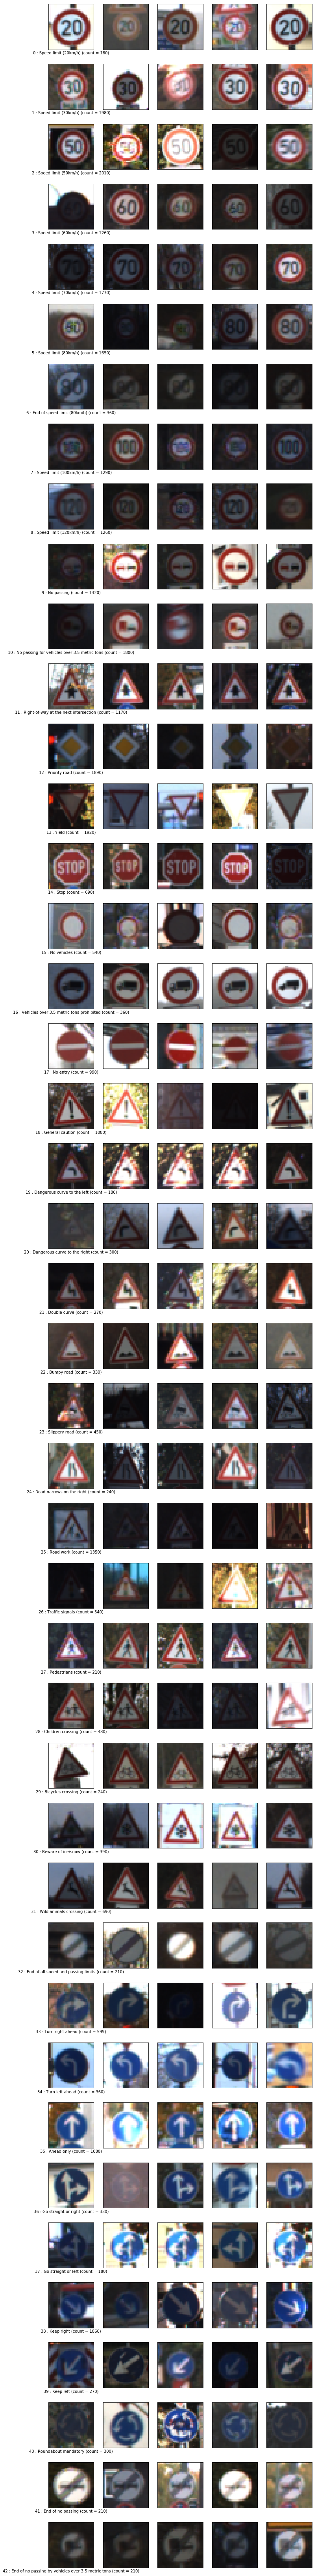

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("Plotting images ... this may take a few seconds")
fig = plt.figure(figsize=(12,120))
numsamples = 5
for ii in range(numsigns):
    indices = np.nonzero(y_train==ii)[0]
    np.random.shuffle(indices)
    for jj in range(min(numsamples,len(indices))):
        index = indices[jj]
        image = X_train[index].squeeze()
        ax = plt.subplot(numsigns,numsamples,numsamples*ii+jj+1)
        plt.imshow(image)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        if(jj==0):
            ax.set_xlabel("%d : %s (count = %d)" % (ii,signnames[ii],len(indices)))


### Plot a histogram indicating the number of each type of image.

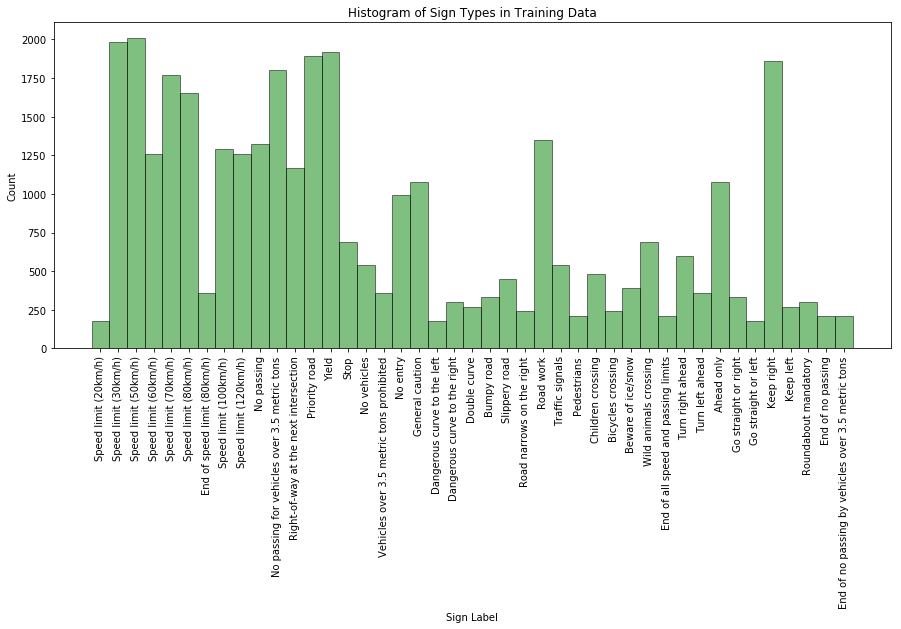

In [4]:
plt.figure(figsize=(15,6))
plt.hist(y_train, bins=numsigns, range=(0,43), facecolor='green', edgecolor='black', alpha=0.5);
plt.xlabel("Sign Label");
plt.ylabel("Count");
plt.title("Histogram of Sign Types in Training Data")
x_pos = np.arange(numsigns)+0.5
ax = plt.gca()
ax.set_xticks(x_pos)
names = list(signnames.values())
ax.set_xticklabels(names, rotation='vertical');

----
## Step 2. Preprocess the Data

### Define the pre-processing of each image (conversion to grayscale, and normalization)

In [5]:
def preProcess(X):
    X = X.astype(np.float)

    # Make grayscale
    X = np.mean(X,axis=3)
    X = X[...,None]
    
    # Normalize
    for ii in range(X.shape[0]):
        meanval = np.mean(X[ii])
        stdval = np.std(X[ii])
        X[ii] = (X[ii] - meanval)/stdval
        
    return X

### Exploit symmetry in the data, to generate additional training data.
* Some of the image classes are closed under horizontal flipping.  For example, a "yield" sign remains a "yield" sign after horizontal flipping.  
* Furthermore, some pairs of classes are complementary under horizontal flipping.  For example, "Keep Left" signs become "Keep Right" signs under horizontal flipping.
* Using these elementary symmetries allows us to augment the data set with 13469 additional images. 

In [6]:
from sklearn.utils import shuffle

def augmentData(X,y):
    # Augment data through trivial reflections
    xflip = [11,12,13,15,17,18,22,30,35]
    swaps = ((19,20),(33,34),(36,37),(38,39))

    xadd = []
    yadd = []
    for label in xflip:
        ind = np.nonzero(y==label)    
        xadd.extend(np.flip(X[ind],axis=2))
        yadd.extend(y[ind])

    for s1,s2 in swaps:
        ind1 = np.nonzero(y==s1) 
        xadd.extend(np.flip(X[ind1],axis=2))
        yadd.extend(s2*np.ones_like(y[ind1]))

        ind2 = np.nonzero(y==s2) 
        xadd.extend(np.flip(X[ind2],axis=2))
        yadd.extend(s1*np.ones_like(y[ind2]))

    xadd = np.array(xadd)
    yadd = np.array(yadd)
    X = np.concatenate((X,xadd),axis=0)
    y = np.concatenate((y,yadd),axis=0)
    
    print("Augmented the image set with {} additional images using symmetry.".format(yadd.size))
    
    return X,y

### Pre-process all the images.  Also, augment the training set.

In [7]:
X_train,y_train = augmentData(X_train,y_train)
X_train = preProcess(X_train)
X_train, y_train = shuffle(X_train, y_train)

X_valid = preProcess(X_valid)
X_test = preProcess(X_test)

Augmented the image set with 13469 additional images using symmetry.


### Use the Keras ImageDataGenerator() class to further augment the data.
* The ImageDataGenerator class allows for generation of additional data by applying rotations, shifts, zooming, and shearing to the images in the original dataset.
* We define the parameters of the ImageDataGenerator() class here.
* During training, we will use the ImageDataGenerator.flow() method to generate new data "inline" as the training epochs proceed.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None)

Using TensorFlow backend.


---
## Step 3. Define the Model Architecture
### Define the layers in the deep learning network. 
* After some experimentation, the final architecture consists of two convolutional layers, and three fully connected layers.  Drop-out is used to provide regularization.

In [9]:
import tensorflow as tf

EPOCHS = 15
BATCH_SIZE = 128
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0.0
sigma = 0.1

# TF placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) 
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, numsigns)
keep_prob = tf.placeholder(tf.float32)

# Layer 1: Convolutional.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(6))
conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

# Activation.
conv1 = tf.nn.relu(conv1)

# Drop out
conv1 = tf.nn.dropout(conv1, keep_prob)

#     # Pooling. Input = 28x28x6. Output = 14x14x6.
#     conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 2: Convolutional. Output = 10x10x16.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

# Activation.
conv2 = tf.nn.relu(conv2)

# Drop out
conv2 = tf.nn.dropout(conv2, keep_prob)

#     # Pooling. Input = 10x10x16. Output = 5x5x16.
#     conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flatten. Input = 5x5x16. Output = 400.
fc0   = flatten(conv2)

# Layer 3: Fully Connected. Input = 400. Output = 120.
fc1_W = tf.Variable(tf.truncated_normal(shape=(9216, 120), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(120))
fc1   = tf.matmul(fc0, fc1_W) + fc1_b

# Activation.
fc1    = tf.nn.relu(fc1)

# Drop out
fc1 = tf.nn.dropout(fc1, keep_prob)

# Layer 4: Fully Connected. Input = 120. Output = 84.
fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(84))
fc2    = tf.matmul(fc1, fc2_W) + fc2_b

# Activation.
fc2    = tf.nn.relu(fc2)

# Layer 5: Fully Connected. Input = 84. Output = 43.
fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(43))
logits = tf.matmul(fc2, fc3_W) + fc3_b
    

---
## Step 4.  Train and Validate the Model
### Define functional objects for use in TensorFlow. 

In [10]:
rate = 0.001

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Unleash the training iterations.

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
#         for offset in range(0, num_examples, BATCH_SIZE):
#             end = offset + BATCH_SIZE
#             batch_x, batch_y = X_train[offset:end], y_train[offset:end]
        batches = 0   
        for batch_x, batch_y in datagen.flow(X_train, y_train, batch_size=BATCH_SIZE):
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            batches += 1
            if batches >= len(X_train) / BATCH_SIZE:
                break
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './trafficsign')
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.712

EPOCH 2 ...
Validation Accuracy = 0.839

EPOCH 3 ...
Validation Accuracy = 0.895

EPOCH 4 ...
Validation Accuracy = 0.920

EPOCH 5 ...
Validation Accuracy = 0.920

EPOCH 6 ...
Validation Accuracy = 0.939

EPOCH 7 ...
Validation Accuracy = 0.945

EPOCH 8 ...
Validation Accuracy = 0.945

EPOCH 9 ...
Validation Accuracy = 0.948

EPOCH 10 ...
Validation Accuracy = 0.956

EPOCH 11 ...
Validation Accuracy = 0.959

EPOCH 12 ...
Validation Accuracy = 0.957

EPOCH 13 ...
Validation Accuracy = 0.969

EPOCH 14 ...
Validation Accuracy = 0.966

EPOCH 15 ...
Validation Accuracy = 0.968

Model saved


---
## Step 5. Test Performance of the Trained Model on the Test Data  

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("\nAccuracy on Test Images = {:.3f}".format(test_accuracy))


Accuracy on Test Images = 0.950


---
## Step 6. Test the Trained Model on New Images

### Load and plot the new images.

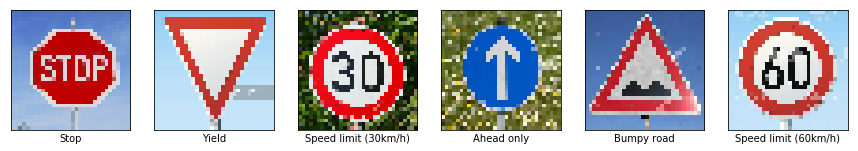

In [13]:
from skimage.transform import resize
from skimage.io import imread

pics0 = []
for ii in range(6):
    fname = "data/signs/sign{}.jpg".format(ii)
    image = imread(fname)
    image = resize(image,(32,32,3),mode='reflect')
    pics0.append(image)

ylabels0 = [14,13,1,35,22,3]    

plt.figure(figsize=(15,3))
for ii,pic in enumerate(pics0):
    ax = plt.subplot(1,6,ii+1)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.xlabel(signnames[ylabels0[ii]])
    plt.imshow(pic)

pics = np.array(pics0)

### Pre-process the new image data

In [14]:
X_pics = preProcess(pics)

### Evaluate the model accuracy on the new image data

In [15]:
feed_dict_top = {x:X_pics,keep_prob: 1}
labels_pred = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'));
    predictions = sess.run(labels_pred,feed_dict = feed_dict_top)
    mytop5 = sess.run(tf.nn.top_k(tf.constant(predictions), k=5))
    new_accuracy = evaluate(X_pics, ylabels0)

print("\n\nClassification accuracy percentage on new images : {0:.1f}%\n".format(new_accuracy*100))



Classification accuracy percentage on new images : 100.0%



### Plot the classification results

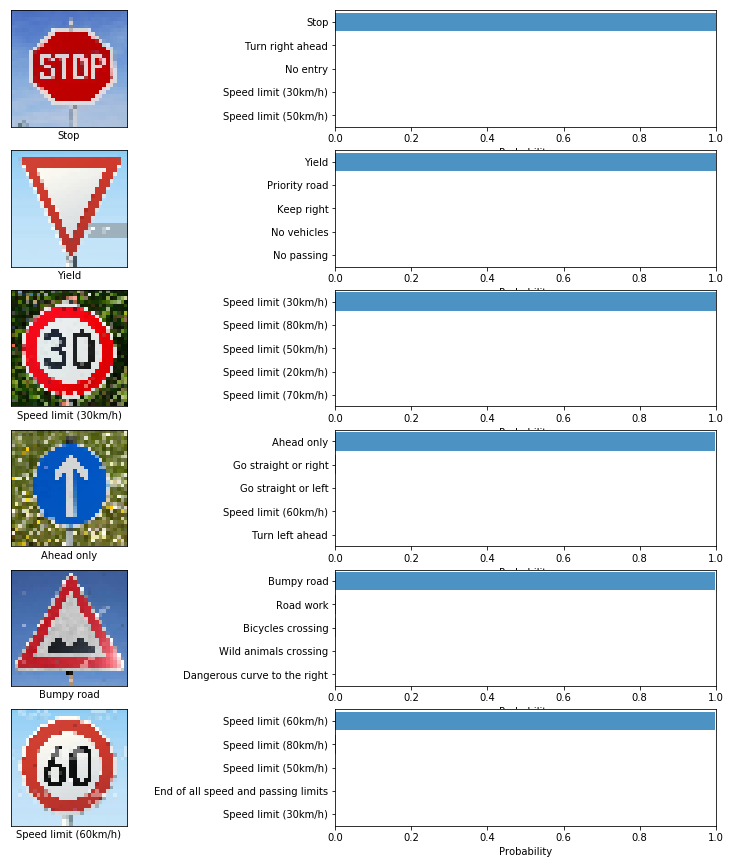

In [16]:
plt.figure(figsize=(15,15))
for ii,pic in enumerate(pics0):
    objects = [signnames[lab] for lab in mytop5.indices[ii]]
    y_pos = np.arange(len(objects))+0.5
    performance = mytop5.values[ii]
    ax = plt.subplot(6,2,2*ii+1)
    plt.imshow(np.squeeze(pic))
    plt.xlabel(signnames[ylabels0[ii]])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax = plt.subplot(6,2,2*ii+2)
    ax.barh(y_pos, performance, align='center', alpha=0.8)
    ax.invert_yaxis()
    plt.axis([0.0,1.0,5.0,0.0])
    plt.yticks(y_pos, objects)
    plt.xlabel('Probability')
#     plt.title('Classification Probabilities')
 
plt.show()

---
## Step 7. Visualize the Neural Network's State with Test Images
### Define the network state visualizer.

In [17]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    pimg = preProcess(image_input)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'));
        activation = tf_activation.eval(session=sess,feed_dict={x : pimg, keep_prob : 0.5})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        ax = plt.subplot(6,8, 1)
        plt.imshow(np.squeeze(image_input))
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        for featuremap in range(featuremaps):
            ax = plt.subplot(6,9, featuremap+2) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 and activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

### Visualize the network state for each new image at the first convolutional layer.

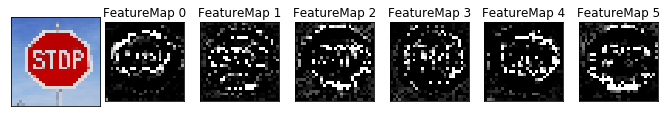

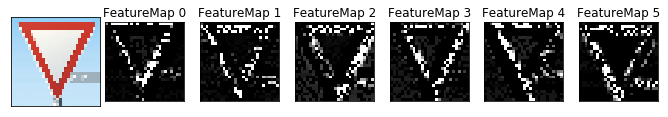

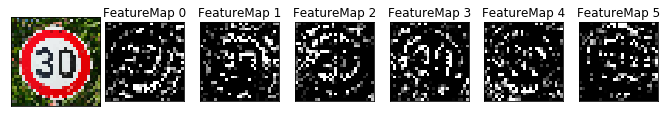

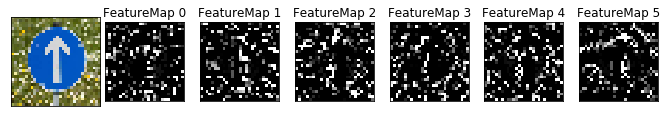

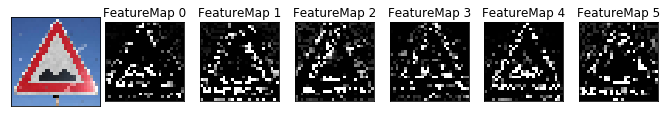

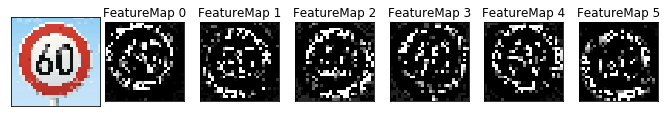

In [18]:
for ii,pic in enumerate(pics0):
    featpic = pic[None,...]
    outputFeatureMap(featpic, conv1,-1.0,1.0,ii)